# CNN + MaxPool
Previously, MCC improved slightly with 
reducing num conv filters from 128 to 64 
or num conv layers from 4 to 2.

We still saw massive overfitting.

Here, shrink the model to one conv layer.

We still observe overfitting, but for the first time since CONV_250, we see over 50% accuracy on the validation set. It would do better with fewer epochs. This is our best so far. 

In [25]:
from datetime import datetime
print(datetime.now())

2023-03-21 16:20:18.085113


In [26]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [27]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [28]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [29]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [30]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [31]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    #pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    #cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    #cnn.add(cnn3_layer)
    #cnn.add(cnn4_layer)
    #cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [32]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 16:20:21.123290
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 conv1d_66 (Conv1D)          (None, 4990, 64)          2112      
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 1246, 64)         0         
 g1D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 79744)             0         
                                                                 
 dropout_22 (Dropout)        (None, 79744)             0         
                                                                 
 dense_22 (Dense)            (None, 1)                 79745     
                          

## Training

In [33]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [34]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 16:20:21.293718
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 16:20:29.015445

Training # 1 1
2023-03-21 16:20:29.015588
2023-03-21 16:20:29.015637
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 16:20:30.315606


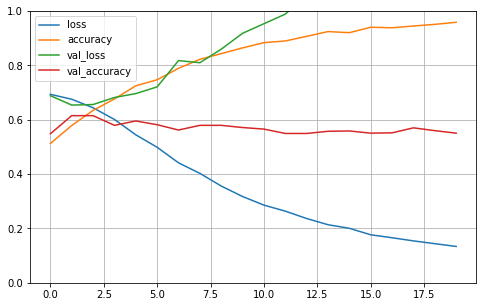


2023-03-21 16:20:53.797899

Testing # 1 1
2023-03-21 16:20:53.798023
2023-03-21 16:20:53.798072
PREDICT
2023-03-21 16:20:54.023596
Test 1:0 458:412 52.64%
Predict 1:0 507:363 58.28%
Test sizes (870, 4997) (870,)
Range of scores: 6.023344e-08 to 0.9999968
Score threshold 0.5
Confusion matrix
 [[192 220]
 [171 287]]
Normalized matrix
 [[0.22068966 0.25287356]
 [0.19655172 0.32988506]]


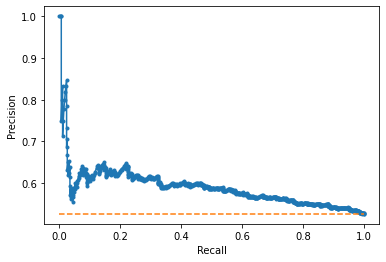

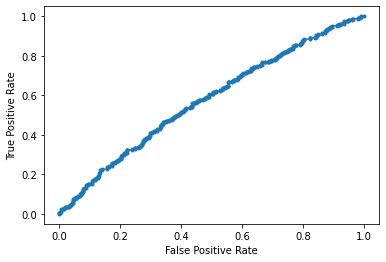

Accuracy: 55.06% Precision: 56.61% Recall: 62.66%
F1: 59.48% MCC: 0.0938
AUPRC: 59.07% AUROC: 57.61%
 accuracy [55.05747126436782]
 precision [56.60749506903353]
 recall [62.66375545851528]
 F1 [59.4818652849741]
 MCC [0.09382145388399685]
 AUPRC [59.07272849369903]
 AUROC [57.613568915080336]
2023-03-21 16:20:55.131632

Training # 1 2
2023-03-21 16:20:55.132322
2023-03-21 16:20:55.132368
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 16:20:56.284485


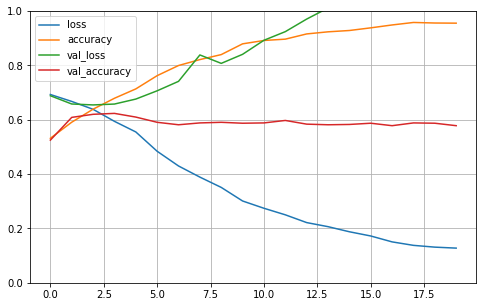


2023-03-21 16:21:38.465153

Testing # 1 2
2023-03-21 16:21:38.465241
2023-03-21 16:21:38.465276
PREDICT
2023-03-21 16:21:38.689166
Test 1:0 442:442 50.00%
Predict 1:0 421:463 47.62%
Test sizes (884, 4997) (884,)
Range of scores: 8.3358765e-07 to 1.0
Score threshold 0.5
Confusion matrix
 [[266 176]
 [197 245]]
Normalized matrix
 [[0.30090498 0.19909502]
 [0.22285068 0.27714932]]


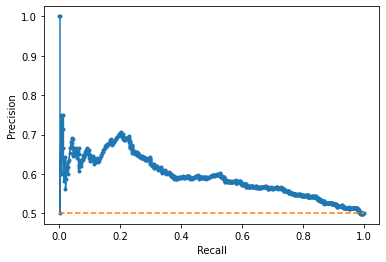

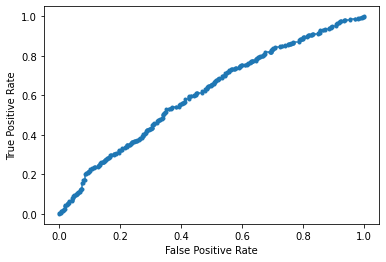

Accuracy: 57.81% Precision: 58.19% Recall: 55.43%
F1: 56.78% MCC: 0.1563
AUPRC: 59.35% AUROC: 61.07%
 accuracy [57.80542986425339]
 precision [58.19477434679335]
 recall [55.42986425339367]
 F1 [56.77867902665121]
 MCC [0.15628509004563412]
 AUPRC [59.35424992570708]
 AUROC [61.071128764767316]
2023-03-21 16:21:39.333061

Training # 1 3
2023-03-21 16:21:39.333198
2023-03-21 16:21:39.333242
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 16:21:40.489506


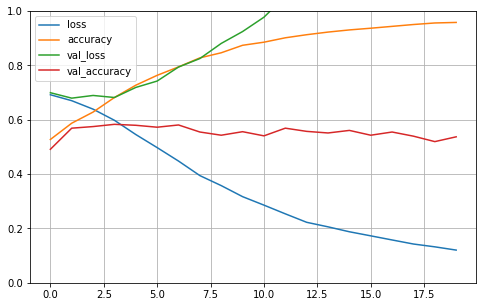


2023-03-21 16:22:22.790858

Testing # 1 3
2023-03-21 16:22:22.790963
2023-03-21 16:22:22.791009
PREDICT
2023-03-21 16:22:23.005412
Test 1:0 442:407 52.06%
Predict 1:0 449:400 52.89%
Test sizes (849, 4997) (849,)
Range of scores: 2.7116839e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[207 200]
 [193 249]]
Normalized matrix
 [[0.24381625 0.23557126]
 [0.22732627 0.29328622]]


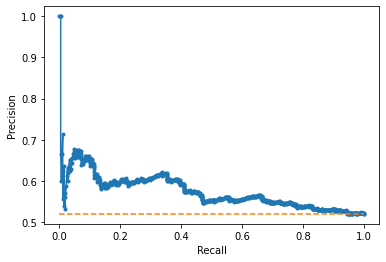

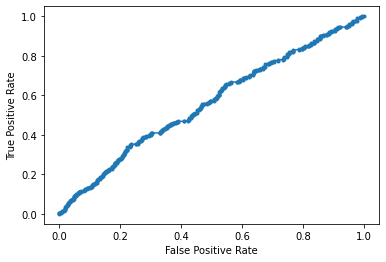

Accuracy: 53.71% Precision: 55.46% Recall: 56.33%
F1: 55.89% MCC: 0.0720
AUPRC: 57.54% AUROC: 55.99%
 accuracy [53.71024734982333]
 precision [55.45657015590201]
 recall [56.334841628959275]
 F1 [55.89225589225588]
 MCC [0.07200678914414091]
 AUPRC [57.53548760201064]
 AUROC [55.991583932760406]
2023-03-21 16:22:23.588252

Training # 1 4
2023-03-21 16:22:23.588873
2023-03-21 16:22:23.588917
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 16:22:24.748620


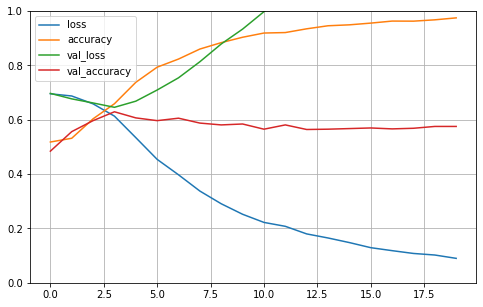


2023-03-21 16:23:06.819862

Testing # 1 4
2023-03-21 16:23:06.820317
2023-03-21 16:23:06.820355
PREDICT
2023-03-21 16:23:07.045245
Test 1:0 459:431 51.57%
Predict 1:0 437:453 49.10%
Test sizes (890, 4997) (890,)
Range of scores: 5.839537e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[253 178]
 [200 259]]
Normalized matrix
 [[0.28426966 0.2       ]
 [0.2247191  0.29101124]]


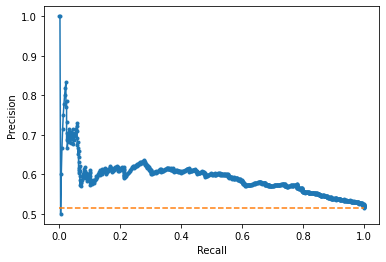

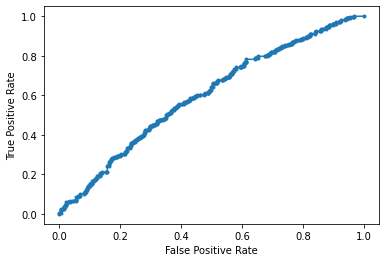

Accuracy: 57.53% Precision: 59.27% Recall: 56.43%
F1: 57.81% MCC: 0.1512
AUPRC: 59.34% AUROC: 60.07%
 accuracy [57.528089887640455]
 precision [59.26773455377574]
 recall [56.42701525054466]
 F1 [57.8125]
 MCC [0.15122666901324455]
 AUPRC [59.33911030468701]
 AUROC [60.071071480925454]
2023-03-21 16:23:07.695623

Training # 1 5
2023-03-21 16:23:07.696646
2023-03-21 16:23:07.696697
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 16:23:08.911699


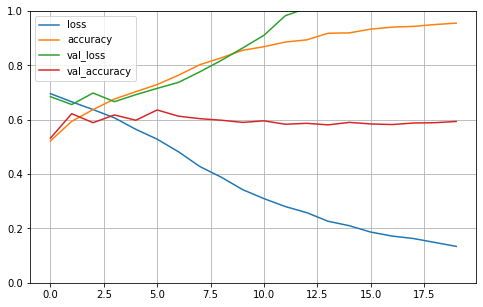


2023-03-21 16:23:50.968684

Testing # 1 5
2023-03-21 16:23:50.968779
2023-03-21 16:23:50.968816
PREDICT
2023-03-21 16:23:51.179560
Test 1:0 457:419 52.17%
Predict 1:0 541:335 61.76%
Test sizes (876, 4997) (876,)
Range of scores: 1.5491717e-07 to 0.99999905
Score threshold 0.5
Confusion matrix
 [[199 220]
 [136 321]]
Normalized matrix
 [[0.22716895 0.25114155]
 [0.15525114 0.36643836]]


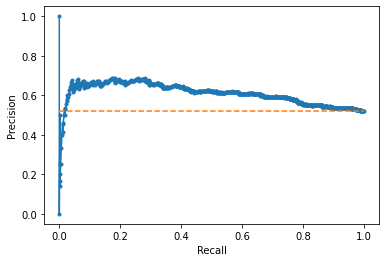

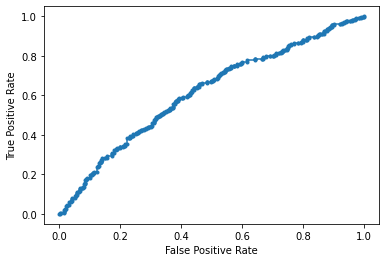

Accuracy: 59.36% Precision: 59.33% Recall: 70.24%
F1: 64.33% MCC: 0.1823
AUPRC: 60.84% AUROC: 61.43%
 accuracy [59.3607305936073]
 precision [59.33456561922365]
 recall [70.24070021881839]
 F1 [64.32865731462925]
 MCC [0.1822924766593594]
 AUPRC [60.83725983958712]
 AUROC [61.42581847996951]
2023-03-21 16:23:51.791342

Training # 2 1
2023-03-21 16:23:51.792663
2023-03-21 16:23:51.792712
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 16:23:52.945888


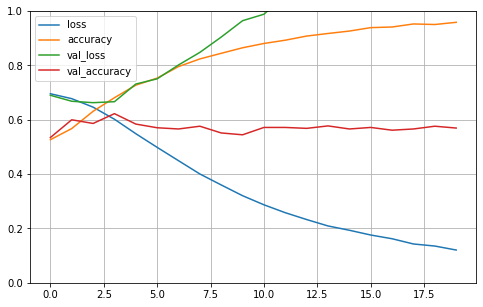


2023-03-21 16:24:16.322040

Testing # 2 1
2023-03-21 16:24:16.323443
2023-03-21 16:24:16.323763
PREDICT
2023-03-21 16:24:16.754812
Test 1:0 472:415 53.21%
Predict 1:0 450:437 50.73%
Test sizes (887, 4997) (887,)
Range of scores: 4.6004637e-08 to 0.9999995
Score threshold 0.5
Confusion matrix
 [[235 180]
 [202 270]]
Normalized matrix
 [[0.26493799 0.20293123]
 [0.22773393 0.30439684]]


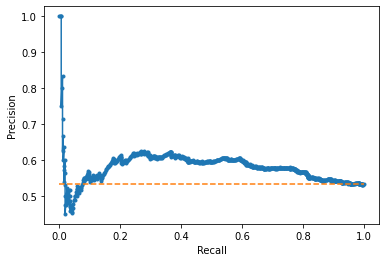

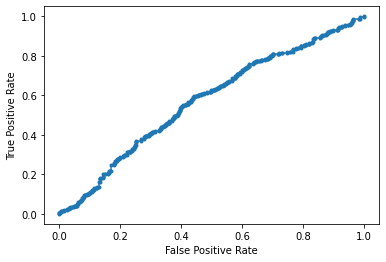

Accuracy: 56.93% Precision: 60.00% Recall: 57.20%
F1: 58.57% MCC: 0.1380
AUPRC: 58.00% AUROC: 57.41%
 accuracy [56.93348365276212]
 precision [60.0]
 recall [57.20338983050848]
 F1 [58.56832971800434]
 MCC [0.13802793224157053]
 AUPRC [58.000655519236176]
 AUROC [57.40657545435981]
2023-03-21 16:24:17.526942

Training # 2 2
2023-03-21 16:24:17.527539
2023-03-21 16:24:17.527612
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 16:24:18.724460


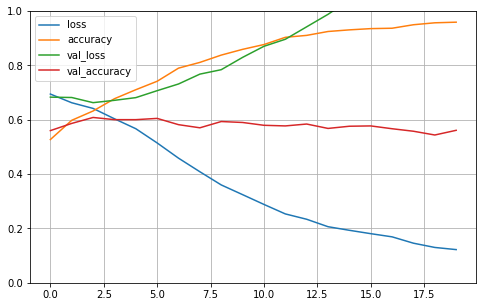


2023-03-21 16:24:45.585809

Testing # 2 2
2023-03-21 16:24:45.585906
2023-03-21 16:24:45.585943
PREDICT
2023-03-21 16:24:45.814358
Test 1:0 452:416 52.07%
Predict 1:0 481:387 55.41%
Test sizes (868, 4997) (868,)
Range of scores: 1.7255593e-06 to 0.9999989
Score threshold 0.5
Confusion matrix
 [[211 205]
 [176 276]]
Normalized matrix
 [[0.24308756 0.23617512]
 [0.20276498 0.31797235]]


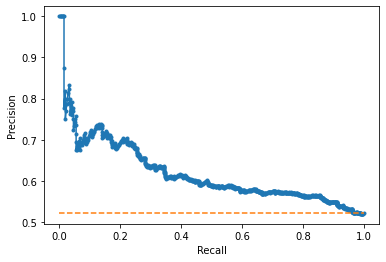

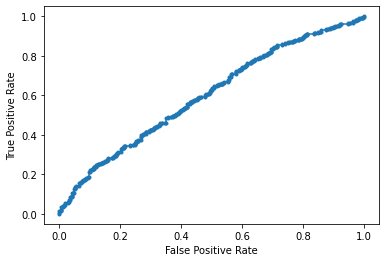

Accuracy: 56.11% Precision: 57.38% Recall: 61.06%
F1: 59.16% MCC: 0.1184
AUPRC: 61.98% AUROC: 60.12%
 accuracy [56.10599078341014]
 precision [57.380457380457386]
 recall [61.06194690265486]
 F1 [59.16398713826365]
 MCC [0.11842610700782516]
 AUPRC [61.98057175133822]
 AUROC [60.12274506466985]
2023-03-21 16:24:46.463491

Training # 2 3
2023-03-21 16:24:46.463613
2023-03-21 16:24:46.463653
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 16:24:47.625846


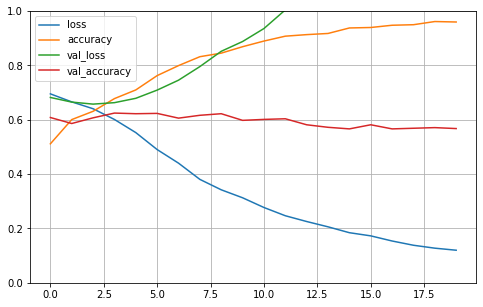


2023-03-21 16:25:12.247664

Testing # 2 3
2023-03-21 16:25:12.247766
2023-03-21 16:25:12.247800
PREDICT
2023-03-21 16:25:12.523334
Test 1:0 453:407 52.67%
Predict 1:0 443:417 51.51%
Test sizes (860, 4997) (860,)
Range of scores: 2.1501434e-09 to 0.99999774
Score threshold 0.5
Confusion matrix
 [[226 181]
 [191 262]]
Normalized matrix
 [[0.2627907  0.21046512]
 [0.22209302 0.30465116]]


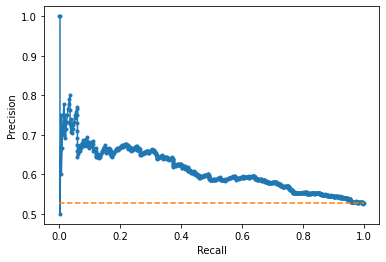

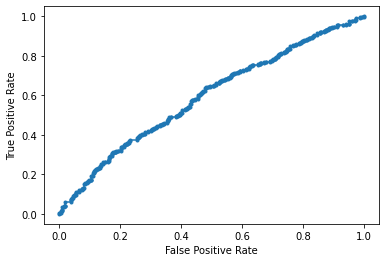

Accuracy: 56.74% Precision: 59.14% Recall: 57.84%
F1: 58.48% MCC: 0.1335
AUPRC: 61.08% AUROC: 59.31%
 accuracy [56.74418604651162]
 precision [59.14221218961625]
 recall [57.836644591611474]
 F1 [58.48214285714285]
 MCC [0.13351871146922636]
 AUPRC [61.07636061876809]
 AUROC [59.30867652721958]
2023-03-21 16:25:13.399855

Training # 2 4
2023-03-21 16:25:13.401827
2023-03-21 16:25:13.402285
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 16:25:14.764992


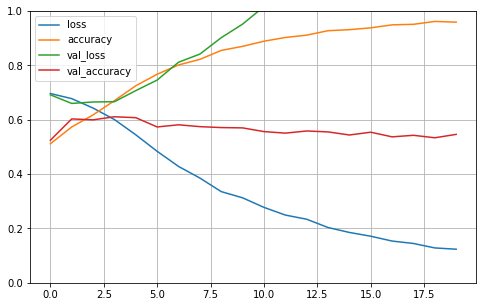


2023-03-21 16:25:57.103391

Testing # 2 4
2023-03-21 16:25:57.103479
2023-03-21 16:25:57.103518
PREDICT
2023-03-21 16:25:57.318916
Test 1:0 432:447 49.15%
Predict 1:0 493:386 56.09%
Test sizes (879, 4997) (879,)
Range of scores: 1.3337368e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[217 230]
 [169 263]]
Normalized matrix
 [[0.24687144 0.26166098]
 [0.19226394 0.29920364]]


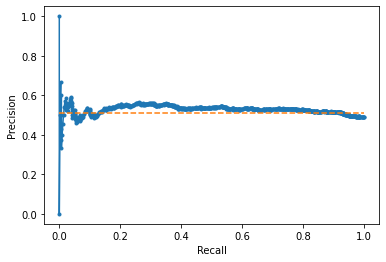

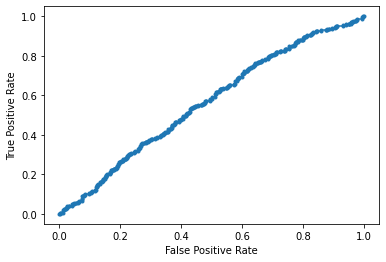

Accuracy: 54.61% Precision: 53.35% Recall: 60.88%
F1: 56.86% MCC: 0.0949
AUPRC: 52.87% AUROC: 56.40%
 accuracy [54.60750853242321]
 precision [53.34685598377283]
 recall [60.879629629629626]
 F1 [56.86486486486487]
 MCC [0.09494727451376665]
 AUPRC [52.86701146205755]
 AUROC [56.398106719695086]
2023-03-21 16:25:57.952938

Training # 2 5
2023-03-21 16:25:57.953053
2023-03-21 16:25:57.953086
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 16:25:59.122424


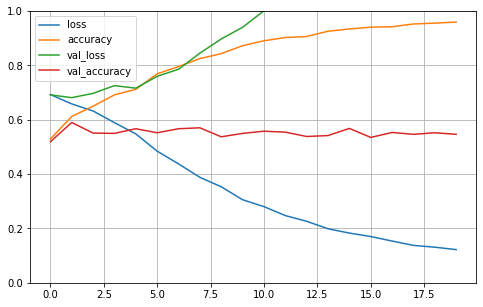


2023-03-21 16:26:23.099145

Testing # 2 5
2023-03-21 16:26:23.099557
2023-03-21 16:26:23.099589
PREDICT
2023-03-21 16:26:23.325385
Test 1:0 449:426 51.31%
Predict 1:0 448:427 51.20%
Test sizes (875, 4997) (875,)
Range of scores: 1.3147356e-08 to 0.9999994
Score threshold 0.5
Confusion matrix
 [[228 198]
 [199 250]]
Normalized matrix
 [[0.26057143 0.22628571]
 [0.22742857 0.28571429]]


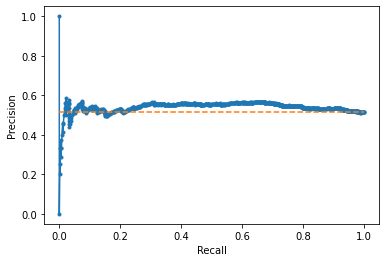

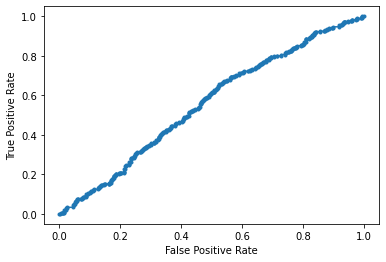

Accuracy: 54.63% Precision: 55.80% Recall: 55.68%
F1: 55.74% MCC: 0.0920
AUPRC: 54.00% AUROC: 55.72%
 accuracy [54.628571428571426]
 precision [55.80357142857143]
 recall [55.67928730512249]
 F1 [55.74136008918617]
 MCC [0.09199885003579777]
 AUPRC [53.99791546124326]
 AUROC [55.721373526982234]
2023-03-21 16:26:23.938071


In [35]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [36]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 56.25% std 1.75
 precision mean 57.45% std 2.13
 recall mean 59.38% std 4.57
 F1 mean 58.31% std 2.48
 MCC mean 0.12% std 0.03
 AUPRC mean 58.41% std 2.96
 AUROC mean 58.51% std 2.14
 accuracy [[55.05747126436782], [57.80542986425339], [53.71024734982333], [57.528089887640455], [59.3607305936073], [56.93348365276212], [56.10599078341014], [56.74418604651162], [54.60750853242321], [54.628571428571426]]
 precision [[56.60749506903353], [58.19477434679335], [55.45657015590201], [59.26773455377574], [59.33456561922365], [60.0], [57.380457380457386], [59.14221218961625], [53.34685598377283], [55.80357142857143]]
 recall [[62.66375545851528], [55.42986425339367], [56.334841628959275], [56.42701525054466], [70.24070021881839], [57.20338983050848], [61.06194690265486], [57.836644591611474], [60.879629629629626], [55.67928730512249]]
 F1 [[59.4818652849741], [56.77867902665121], [55.89225589225588], [57.8125], [64.32865731462925], [58.56832971800434], [59.16398713826365], [58.482